# Quickstart Tutorial
This short demo of the ddl package shows the main interfaces and basic ideas of the library.

(Note that destructors and most components of this library are `scikit-learn` compatible estimators and thus can be seamlessly used within the `scikit-learn` framework.)

In [1]:
# Setup imports
from __future__ import division, print_function
import sys, os, warnings
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')  # Enable importing from package ddl without installing ddl

# Setup plotting functions
%matplotlib inline 
PLOT_HEIGHT = 3
def get_ax(ax, title):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(PLOT_HEIGHT, PLOT_HEIGHT))
        fig.tight_layout()
    if title is not None:
        ax.set_title(title)
    ax.axis('equal')
    ax.set_adjustable('box')
    return ax
def plot_data(X, y, ax=None, title=None):
    ax = get_ax(ax, title)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=4)
def plot_density(density, bounds=[[0, 1], [0, 1]], n_grid=40, ax=None, title=None):
    ax = get_ax(ax, title)
    x = np.linspace(*bounds[0], n_grid)
    y = np.linspace(*bounds[1], n_grid)
    X_grid, Y_grid = np.meshgrid(x, y)
    logpdf = density.score_samples(np.array([X_grid.ravel(), Y_grid.ravel()]).T)
    pdf_grid = np.exp(logpdf).reshape(X_grid.shape)
    ax.pcolormesh(X_grid, Y_grid, -pdf_grid, cmap='gray', zorder=-1)
def plot_multiple(X_arr, y_arr, titles=None):
    if titles is None:
        titles = [None] * len(X_arr)
    n_cols = int(min(4, len(X_arr)))
    n_rows = int(np.ceil(len(X_arr) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(PLOT_HEIGHT * n_cols, PLOT_HEIGHT * n_rows))
    axes = axes.ravel()
    fig.tight_layout()
    for i, (X, y, ax, title) in enumerate(zip(X_arr, y_arr, axes, titles)):
        if hasattr(X, 'score_samples'):
            # Special case of plotting a density instead
            if 'get_prev_bounds' in y:
                if y.pop('get_prev_bounds'):
                    y['bounds'] = [axes[i - 1].get_xlim(), axes[i - 1].get_ylim()]
            plot_density(X, ax=ax, title=title, **y)
        else:
            plot_data(X, y, ax=ax, title=title)
def plot_before_and_after(X, Z, y, destructor, label='destructor'):
    if hasattr(destructor, 'fitted_destructors_'):
        print('Number of layers including initial destructor = %d'
              % len(destructor.fitted_destructors_))
    if hasattr(destructor, 'cv_test_scores_'):
        print('Mean cross-validated test likelihood of selected model: %g' 
              % np.mean(destructor.cv_test_scores_[destructor.best_n_layers_ - 1]))
    get_prev_bounds = ()
    plot_multiple([X, destructor.density_, Z],
                  [y, dict(get_prev_bounds=np.min(X) < 0 or np.max(X) > 1), y], 
                  titles=['Before %s' % label, 'Implicit density', 'After %s' % label])

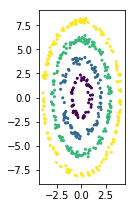

In [2]:
# Make toy dataset to play with
from ddl.datasets import make_toy_data
D = make_toy_data(data_name='concentric_circles', n_samples=500, random_state=0)
X, y = D.X * [1, 2], D.y # Add axis scaling to make it a little more interesting
plot_data(X, y)

## Destructors
Destructors are the building block of everything in the `ddl` library.
At their core, destructors are invertible transformations that project onto the unit hypercube.
Each destructor, explicitly or *implicitly* has a corresponding probabilistic density which is equal to abs(det(Jacobian)).

First, we will give an example of an independent destructor with an *explicit* density.
(Note that when fitting the destructor, the density is fitted first and then the destructor is fitted based on the density. Thus, the density does not need to be fitted a priori.)

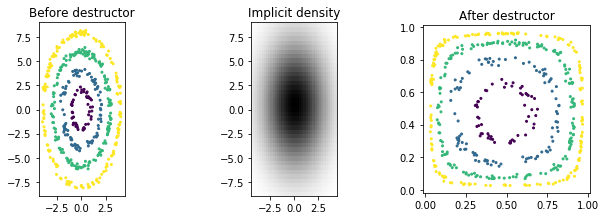

In [3]:
# Independent destructor
from ddl.independent import IndependentDensity, IndependentDestructor
from ddl.univariate import ScipyUnivariateDensity
import scipy.stats

# Create independent Gaussian/normal density
ind_density = IndependentDensity(
    univariate_estimators=ScipyUnivariateDensity(scipy_rv=scipy.stats.norm)
)
# Create corresponding destructor using the explicit density created above
ind_destructor = IndependentDestructor(ind_density)
Z_ind = ind_destructor.fit_transform(X)

plot_before_and_after(X, Z_ind, y, ind_destructor)

Note that data has been transformed onto the unit square.

In [4]:
# Print out mean and variance of estimated independent Gaussians
univ_densities = ind_destructor.density_.univariate_densities_
for i, (mu, sigma) in enumerate([(u.rv_.args[0], u.rv_.args[1]) for u in univ_densities]):
    print('Mean and standard deviation of variable %d: %g, %g' % (i, mu, sigma) )

Mean and standard deviation of variable 0: 0.0571823, 2.19926
Mean and standard deviation of variable 1: 0.325519, 4.34981


Note that the estimated standard deviation for the second variable is twice as much as the first.
Thus, the transformation removes the oval shape of the distribution.

We now present a tree destructor to give another example of a destructor with an explicit density.
Because our tree destructor is a *canonical* destructor (i.e. one whose domain is the unit hypercube), we will use our previously destroyed data `Z_ind` instead of `X`.

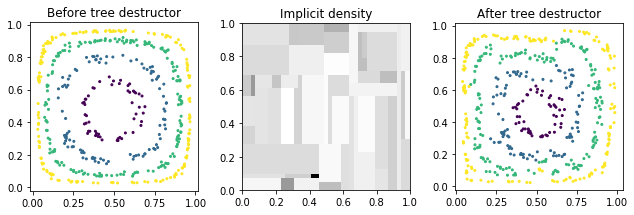

In [5]:
from ddl.tree import TreeDensity, TreeDestructor, RandomTreeEstimator
tree_density = TreeDensity(
    tree_estimator=RandomTreeEstimator(min_samples_leaf=3, random_state=0)
)
tree_destructor = TreeDestructor(tree_density)
Z_tree = tree_destructor.fit_transform(Z_ind)

plot_before_and_after(Z_ind, Z_tree, y, tree_destructor, label='tree destructor')

Note that the tree density is piecewise constant.
(This implies that the destructor is piecewise linear since the density is equal to the abs(det(Jacobian)).)

## Composite destructors (Implicit density)
We will now introduce composite destructors which are simply destructors composed of multiple transformations.
The density for composite destructors is *implicit* based on the transformations in the composition.

*Note that the last transformation must be a true destructor but the other transformations merely need to be invertible.*

We will compose the above two destructors into a single composite destructor.

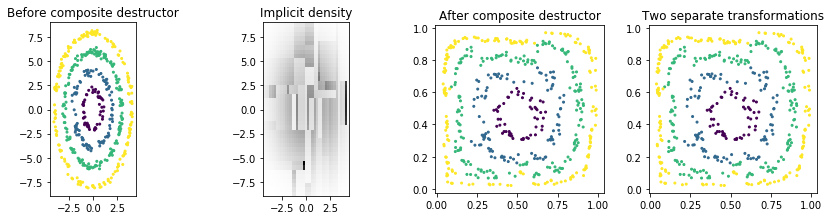

In [6]:
from sklearn.base import clone
from ddl.base import CompositeDestructor
composite_destructor = CompositeDestructor([clone(ind_destructor), clone(tree_destructor)])
Z_tree_2 = composite_destructor.fit_transform(X)
plot_multiple([X, composite_destructor.density_, Z_tree_2, Z_tree], 
              [y, dict(get_prev_bounds=True), y, y], 
              titles=['Before composite destructor', 'Implicit density', 'After composite destructor',
                      'Two separate transformations'])

Notice how the composite destructor does the same thing as doing two sequential, separate transformations (far right).

## Deep destructors
Finally, we will show how to construct a deep destructor that automatically builds up a composite destructor by appending destructors as needed.
(The deep destructor chooses the number of destructors/layers based on cross validation.)

A deep destructor has an initial destructor whose domain can be anything but requires canonical destructors (i.e. destructors whose domain is the unit hypercube) for other transformation layers in the destructor.
Thus, we will use a simple initial destructor and then a tree destructor, which is a canonical destructor by construction.

Number of layers including initial destructor = 4
Mean cross-validated test likelihood of selected model: -5.08567


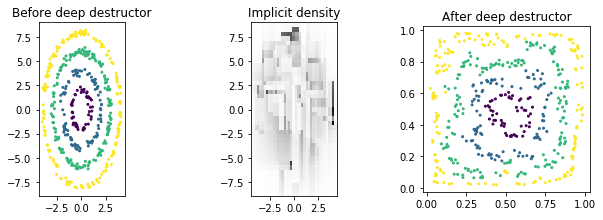

In [7]:
from sklearn.base import clone
from ddl.deep import DeepDestructorCV
deep_destructor = DeepDestructorCV(
    init_destructor=clone(ind_destructor),
    canonical_destructor=clone(tree_destructor),
    cv=3,
    # Because of the randomness in RandomTreeEstimator, 
    #  we continue up to 5 layers even if the test log likelihood goes down.
    n_extend=5, 
)
Z_deep = deep_destructor.fit_transform(X)

plot_before_and_after(X, Z_deep, y, deep_destructor, label='deep destructor')

We can inspect the cross validation results:

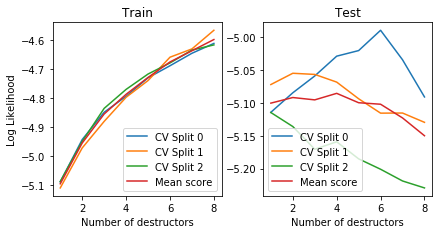

In [8]:
# Compute mean train and test scores
def plot_deep_cv(deep_destructor):
    def get_cv_data(scores):
        # Concatenate scores and mean score
        return np.hstack((scores, np.mean(scores, axis=1).reshape(-1, 1)))

    fig, axes = plt.subplots(1, 2, figsize=(PLOT_HEIGHT * 2, PLOT_HEIGHT))
    fig.tight_layout()
    for cv, label, ax in zip(
            [get_cv_data(deep_destructor.cv_train_scores_), get_cv_data(deep_destructor.cv_test_scores_)], 
            ['Train', 'Test'], axes):
        ax.plot(np.arange(cv.shape[0]) + 1, cv)
        ax.set_title(label)
        if label == 'Train':
            ax.set_ylabel('Log Likelihood')
        ax.set_xlabel('Number of destructors')
        ax.legend(['CV Split %d' % i for i in range(cv.shape[1] - 1)] + ['Mean score'])
plot_deep_cv(deep_destructor)

We also inspect the local densities associated with each destructor/layer of the deep destructor:

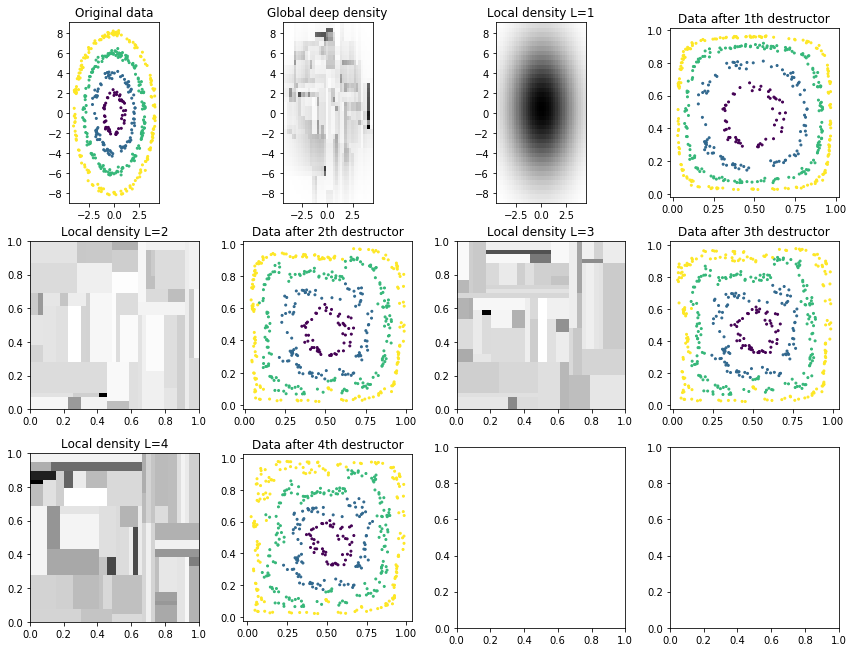

In [9]:
def plot_deep_layers(deep_destructor):
    # Transform up to layer i
    n_layers = len(deep_destructor.fitted_destructors_)
    Z_arr = [deep_destructor.transform(X, partial_idx=np.arange(i + 1)) for i in range(n_layers)]

    # Extract "local" densities corresponding to each layer
    local_densities = [d.density_ for d in deep_destructor.fitted_destructors_]

    # Visualize results 
    X_arr = ([X, deep_destructor.density_]
             + np.array([local_densities, Z_arr]).transpose().ravel().tolist())
    y_arr = ([y, dict(get_prev_bounds=True)]
             + [dict(get_prev_bounds=True), y]
             + np.array([[{}, y] for _ in range(n_layers - 1)]).ravel().tolist())
    titles = (['Original data', 'Global deep density']
              + np.array([
                  ('Local density L=%d' % (i + 1), 'Data after %dth destructor' % (i + 1))
                  for i in range(n_layers)
              ]).ravel().tolist())
    plot_multiple(X_arr, y_arr, titles=titles)
plot_deep_layers(deep_destructor)

Notice how the training log likelihood is always increasing but the test log likelihood is somewhat random.
(The high variance is caused because we use the random-based `RandomTreeEstimator` for estimating tree densities.) 

We can regularize our density estimates by mixing the empirical estimate with a uniform distribution via the `uniform_weight` parameter of the `TreeDestructor`.
This regularization allows for more tree destructor layers because each one does not overfit as much.
However, the deeper destructor also has more parameters and thus a higher computational cost.

Number of layers including initial destructor = 16
Mean cross-validated test likelihood of selected model: -4.95648


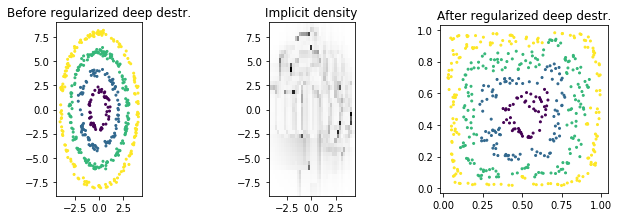

In [10]:
# Update the uniform weight parameter of the tree_density
deep_destructor_reg = clone(deep_destructor).set_params(
    canonical_destructor__tree_density__uniform_weight=0.5
)
Z_deep_reg = deep_destructor_reg.fit_transform(X)
plot_before_and_after(X, Z_deep_reg, y, deep_destructor_reg, 'regularized deep destr.')

Notice that now the *regularized* deep estimator has selected 16 layers/destructors instead of 4 and the estimated density is much closer to the true density (-4.97 vs -5.10 mean CV test log likelihood).

We now show cross validation results to show that the test likelihood usually goes up in all CV folds for the regularized deep estimator.

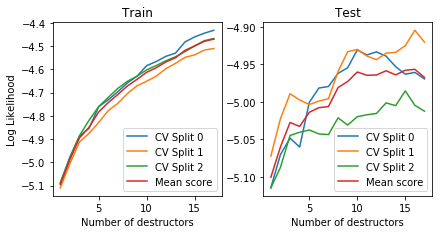

In [11]:
plot_deep_cv(deep_destructor_reg)

We also inspect the local densities associated with each destructor/layer of the deep destructor:

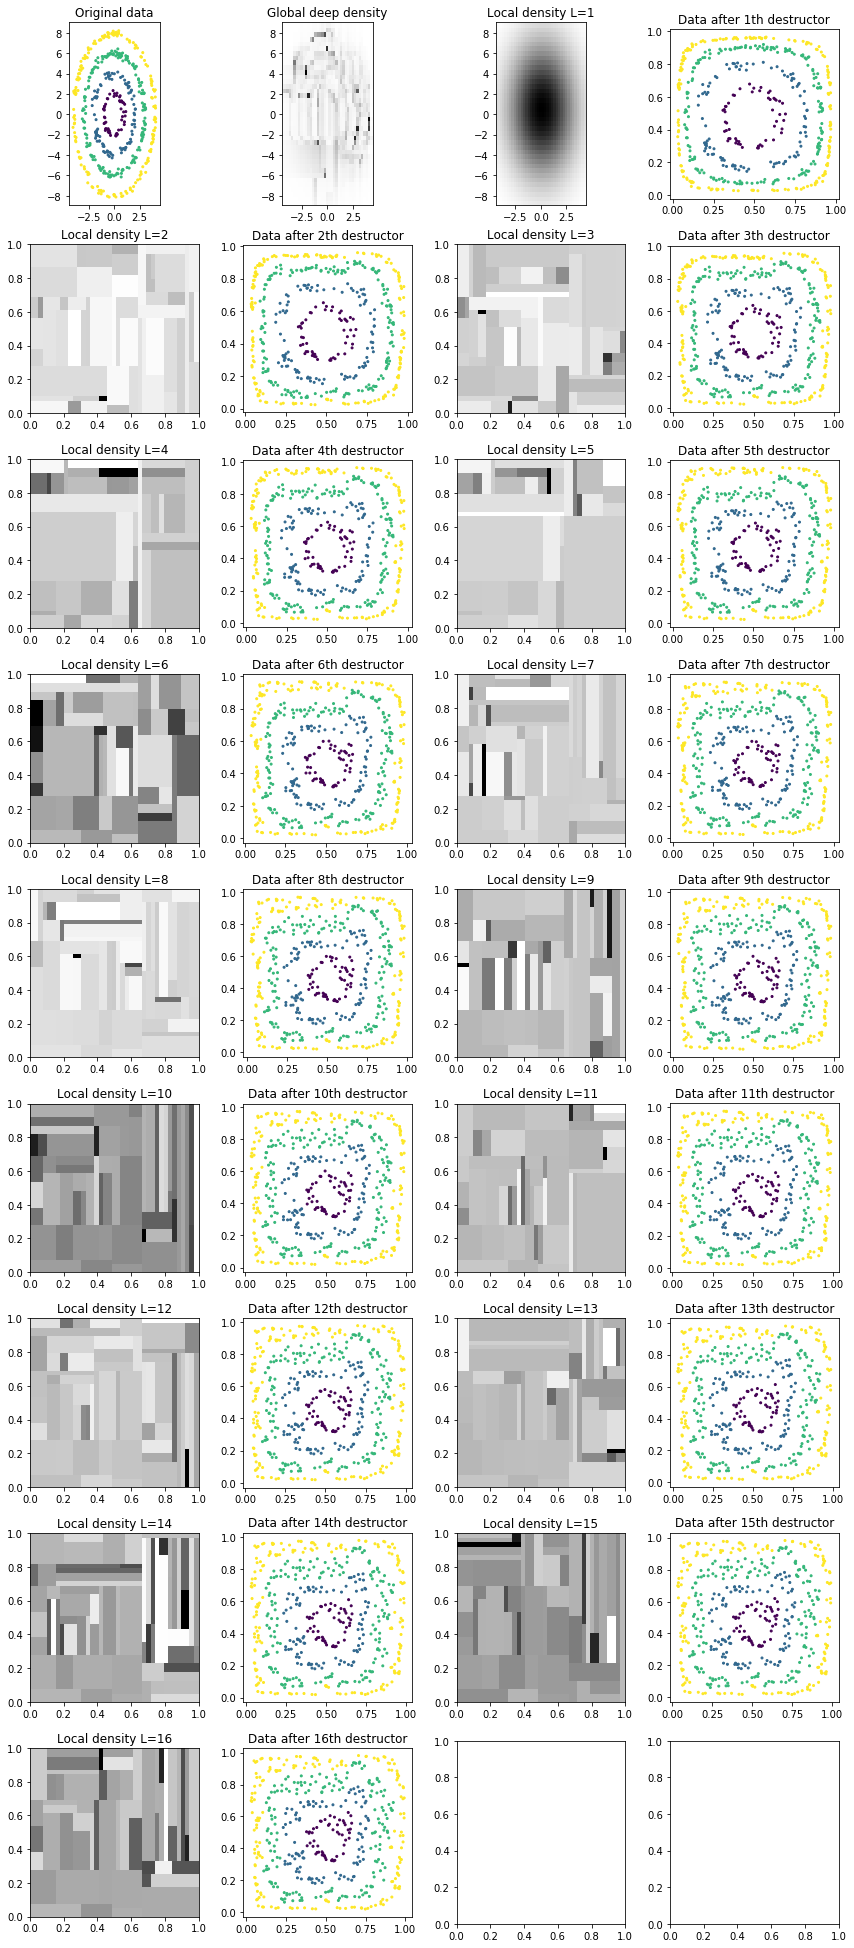

In [12]:
plot_deep_layers(deep_destructor_reg)

## Working with destructors in an unbounded domain (Deep Gaussian copula destructors)
Though canonical destructors require the domain to be the unit hypercube, we can use destructors defined on unbounded spaces by preprending a simple inverse Gaussian CDF transformation.
Note that this trick is useful whenever linear methods (i.e. multiplying the data by a matrix) is required for a destructor.

(*Some intuition*: If the distribution had support on the unit hypercube and then was multiplied by a matrix, the support of the new distribution is some odd rotated hypercube.  However, if the space is the whole real space and then is rotated, the output is still on the whole real space.)

We will illustrate this perspective by constructing a deep Gaussian copula destructor.
To create a canonical destructor, we will create a composite destructor with the following steps:
1. Make the marginals uniform by estimating independent histograms for each dimension on [0,1]---note that the histograms are defined on the bounded domain [0,1] since histograms are inherently bounded density estimators. (The `alpha` pseudo-counts parameter is the main histogram regularization parameter.)
2. Project to the real space via `IndependentInverseCdf`, which applies the standard normal inverse CDF to each dimension independently.
3. Apply orthogonal rotation/reflection transformation using `scikit-learn`'s `PCA` estimator
4. Apply independent Gaussian destructor (note that mean and variance will be different for each dimension)

Number of layers including initial destructor = 5
Mean cross-validated test likelihood of selected model: -4.83752


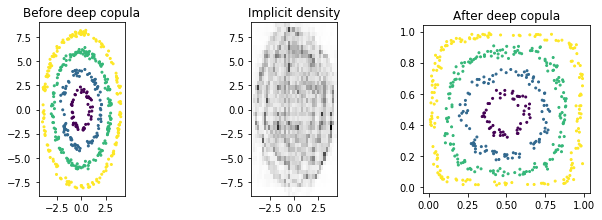

In [13]:
from sklearn.decomposition import PCA
from ddl.univariate import HistogramUnivariateDensity
from ddl.independent import IndependentInverseCdf
from ddl.linear import LinearProjector

deep_copula_destructor = DeepDestructorCV(
    init_destructor=IndependentDestructor(),  # Projects the data onto the unit hypercube
    canonical_destructor=CompositeDestructor([
        IndependentDestructor(IndependentDensity(
            HistogramUnivariateDensity(bounds=[0,1], bins=40, alpha=10),  # Makes the marginals uniform via histogram estimator
        )),
        IndependentInverseCdf(),  # Projects from unit hypercube onto the real-valued space y
        LinearProjector(linear_estimator=PCA()),  # Linearly project onto principal components estimated via PCA
        IndependentDestructor(),  # Estimate independent Gaussian and project onto unit hypercube
    ]),
    cv=3,
    n_extend=5,
)

Z_deep_copula = deep_copula_destructor.fit_transform(X)
plot_before_and_after(X, Z_deep_copula, y, deep_copula_destructor, 'deep copula')

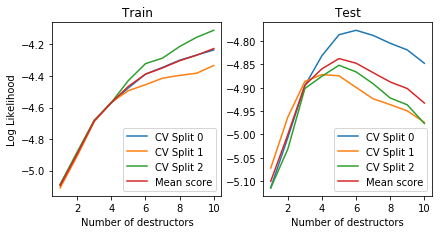

In [14]:
plot_deep_cv(deep_copula_destructor)

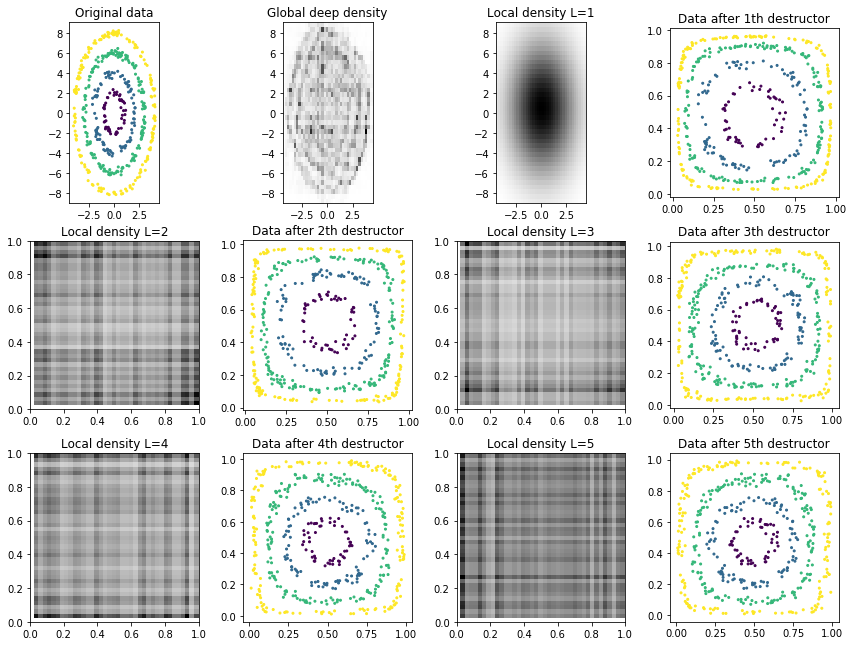

In [15]:
plot_deep_layers(deep_copula_destructor)

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]

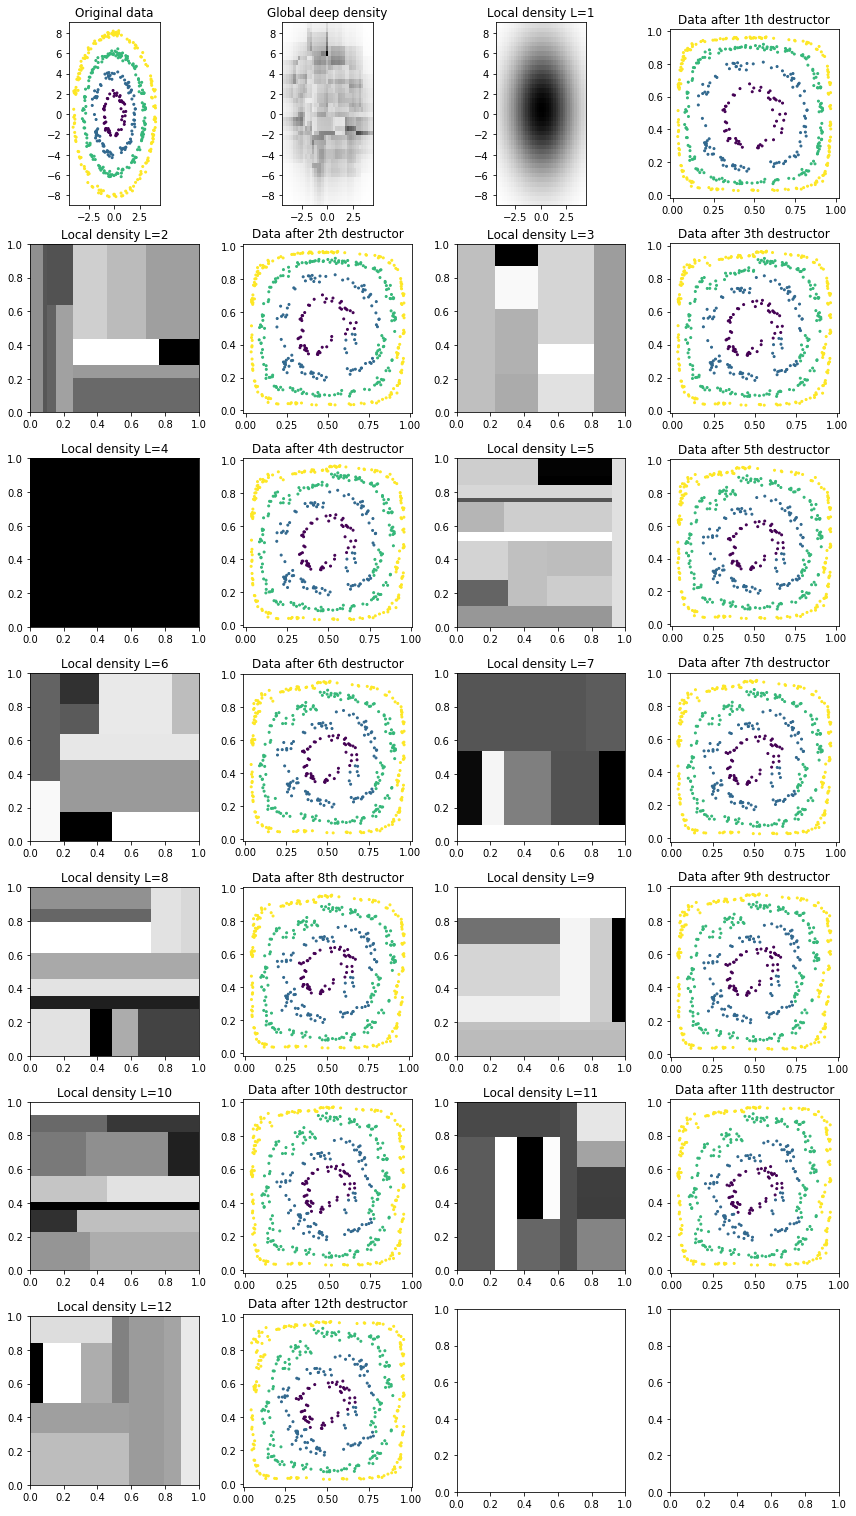

In [16]:
from sklearn.utils import check_random_state
deep_random_destructor = DeepDestructorCV(
    init_destructor=IndependentDestructor(),  # Projects the data onto the unit hypercube
    canonical_destructor=TreeDestructor(tree_density=TreeDensity(
        tree_estimator=RandomTreeEstimator(min_samples_leaf=20),
    )),
    random_state=0,
    cv=3,
    n_extend=5,
)
Z_deep_random = deep_random_destructor.fit_transform(X)
Z_deep_random_2 = deep_random_destructor.fit_transform(X)
print(np.all(Z_deep_random - Z_deep_random_2 == 0)
plot_deep_layers(deep_random_destructor)